# **All Imports**

In [102]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
import sys
import platform
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phrases, Phraser 
import gensim.downloader as gensim_api
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, Input, LSTM, Dense 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import to_categorical
from google.colab import drive

# **All Initializations**

In [103]:
OS = platform.system()   # Operating System
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **All Globals**

In [104]:
pretrained_embeddings = False
benchmark = True
language = "italian" # english
ht_to_exclude = ['#ANSA']
default_callbacks = []
save_best_model = True
early_stopping = False

# **All General Functions Definitions**

In [105]:
def explore_data(data): 
  print("\nHead of Data: \n", data.head())
  print("\nTail of Data: \n", data.tail())
  print("\nShape of Data: ", data.shape)
  print("\nInformation about Data: \n")
  try: 
    data.info()
  except: 
    pass
  print("\nTypes of Data attributes: \n")
  try: 
    data.dtypes
  except: 
    pass
  print("\nSummary of all numerical fields in the dataset: \n")
  try: 
    data.describe(include = [np.number])
  except: 
    pass
  print("\nSummary of all categorical fields in the dataset: \n")
  try: 
    data.describe(include = ['O'])
  except: 
    pass
  print("\nLoop Through Each Column and Check for nulls: \n")
  try: 
    for i in range(len(data.columns)):
        print(data.columns[i] + ": " + str(data[data.columns[i]].isna().sum()))
  except: 
    pass

def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

# Plot the loss function chart
def plot_loss(history = None):
    plt.figure()												# generate a new window
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='upper right')
    plt.show(block=False)
    plt.pause(1)

# Plot the accuracy function chart
def plot_acc(history = None):
    plt.figure()												# generate a new window
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(loc='upper left')
    plt.show(block=False)
    plt.pause(1)

In [106]:
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive')
model_path = "/content/drive/MyDrive/DL_Models/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Download**

In [107]:
if benchmark == True: 
  out = data_download("./News_Category_Dataset_v2.zip", "1O0JTnVgHcYppkR5hmj8sxkpgP4dI164C", OS)
  category_dicts = []
  with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
      for dic in json_file:
          category_dicts.append(json.loads(dic))
else: 
  out = data_download("./tweetHashtah3Giu.zip", "1J2FodTnUeDURmg1I-4AQcbHE0XISILKf", OS)

In [108]:
out

True

# **Data Preprocessing**

In [109]:
if benchmark == True:
  data = pd.DataFrame(category_dicts)
  data = data[data["category"].isin(['ENTERTAINMENT','POLITICS','TECH'])][["category","headline"]]
  data = data.rename(columns={"category":"labels", "headline":"text"})
  data = data[['text', 'labels']]     # move cols
  explore_data(data)
else:
  data = pd.read_csv("./tweetHashtah3Giu.csv")
  explore_data(data)



Head of Data: 
                                                 text         labels
1  Will Smith Joins Diplo And Nicky Jam For The 2...  ENTERTAINMENT
2    Hugh Grant Marries For The First Time At Age 57  ENTERTAINMENT
3  Jim Carrey Blasts 'Castrato' Adam Schiff And D...  ENTERTAINMENT
4  Julianna Margulies Uses Donald Trump Poop Bags...  ENTERTAINMENT
5  Morgan Freeman 'Devastated' That Sexual Harass...  ENTERTAINMENT

Tail of Data: 
                                                      text labels
200844    Google+ Now Open for Teens With Some Safeguards   TECH
200845                                           Web Wars   TECH
200846  First White House Chief Technology Officer, An...   TECH
200847         Watch The Top 9 YouTube Videos Of The Week   TECH
200848  RIM CEO Thorsten Heins' 'Significant' Plans Fo...   TECH

Shape of Data:  (50879, 2)

Information about Data: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50879 entries, 1 to 200848
Data columns (total 2 columns):
 #  

In [110]:
data

,text,labels
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 57,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT
5,Morgan Freeman 'Devastated' That Sexual Harass...,ENTERTAINMENT
...,...,...
200844,Google+ Now Open for Teens With Some Safeguards,TECH
200845,Web Wars,TECH
200846,"First White House Chief Technology Officer, An...",TECH
200847,Watch The Top 9 YouTube Videos Of The Week,TECH


#**Data Exploration**

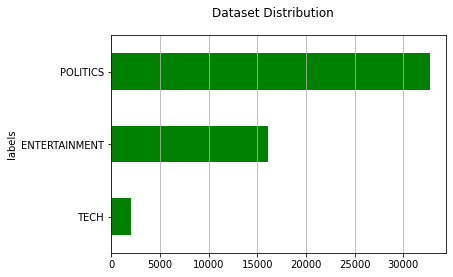

In [111]:
if benchmark == True: 
  fig, ax = plt.subplots()
  fig.suptitle("Dataset Distribution", fontsize=12)
  data["labels"].reset_index().groupby("labels").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax, color = "green").grid(axis='x')
  plt.show()
else:
  fig, ax = plt.subplots()
  fig.suptitle("Hashtags Distribution", fontsize=12)
  data["hashtag"].reset_index().groupby("hashtag").count().sort_values(by="index", ascending = False)[0:10].plot(kind="barh", legend=False, ax=ax, color = "green").grid(axis='x')
  ht = data["hashtag"].reset_index().groupby("hashtag").count().sort_values(by="index", ascending = False)[0:10]
  ht_list = list(ht.index)
  ht_list = C = [x for x in ht_list if x not in ht_to_exclude]    # exclude some hashtags
  plt.show()
  filter = "$|".join(ht_list)
  data = data[data.hashtag.str.contains(filter)]
  data.hashtag.value_counts()
  data = data.rename(columns={"hashtag":"labels", "TEXT":"text"})



In [112]:
filter

'#Draghi$|#redditodicittadinanza$|#3giugno$|#Ucraina$|#4voiceless$|#jeru$|#LiveIn$|#10lezionidipolitica$|#prelemi'

In [113]:
ht_list

['#Draghi',
 '#redditodicittadinanza',
 '#3giugno',
 '#Ucraina',
 '#4voiceless',
 '#jeru',
 '#LiveIn',
 '#10lezionidipolitica',
 '#prelemi']

In [114]:
data.reset_index()

,index,text,labels
0,1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
1,2,Hugh Grant Marries For The First Time At Age 57,ENTERTAINMENT
2,3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
3,4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT
4,5,Morgan Freeman 'Devastated' That Sexual Harass...,ENTERTAINMENT
...,...,...,...
50874,200844,Google+ Now Open for Teens With Some Safeguards,TECH
50875,200845,Web Wars,TECH
50876,200846,"First White House Chief Technology Officer, An...",TECH
50877,200847,Watch The Top 9 YouTube Videos Of The Week,TECH


# **Data Cleaning Function Definition**

In [115]:
def clean_text(text, stemming=False, remove_stopwords = True, lemmatization=True, language = language, print_stopwords = False):
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip()) # (1)  
  lst_text = text.split()                                  # (2)
  if remove_stopwords: 
    lst_stopwords = nltk.corpus.stopwords.words(language)
    
    if lst_stopwords is not None:                          # (3)
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    if print_stopwords: 
      print(lst_text)

  if stemming:                                             # (4)
      ps = nltk.stem.porter.PorterStemmer()
      lst_text = [ps.stem(word) for word in lst_text]
              
  if lemmatization:                                        # (5) 
      lem = nltk.stem.wordnet.WordNetLemmatizer()
      lst_text = [lem.lemmatize(word) for word in lst_text]
          
  text = " ".join(lst_text)                                # (6)
  
  return text

# **Data Cleaning**

In [116]:
data["text_clean"] = data["text"].apply(lambda x: clean_text(x, remove_stopwords = True, stemming=False, lemmatization=False)) 
explore_data(data)


Head of Data: 
                                                 text         labels  \
1  Will Smith Joins Diplo And Nicky Jam For The 2...  ENTERTAINMENT   
2    Hugh Grant Marries For The First Time At Age 57  ENTERTAINMENT   
3  Jim Carrey Blasts 'Castrato' Adam Schiff And D...  ENTERTAINMENT   
4  Julianna Margulies Uses Donald Trump Poop Bags...  ENTERTAINMENT   
5  Morgan Freeman 'Devastated' That Sexual Harass...  ENTERTAINMENT   

                                          text_clean  
1  will smith joins diplo and nicky jam for the 2...  
2    hugh grant marries for the first time at age 57  
3  jim carrey blasts castrato adam schiff and dem...  
4  julianna margulies uses donald trump poop bags...  
5  morgan freeman devastated that sexual harassme...  

Tail of Data: 
                                                      text labels  \
200844    Google+ Now Open for Teens With Some Safeguards   TECH   
200845                                           Web Wars   TECH   
20084

# **Data Preparation**

In [117]:
train_set, test_set = train_test_split(data, test_size=0.2)
train_y = train_set["labels"].values
test_y = test_set["labels"].values

In [118]:
print(len(train_set))
print(len(test_set))
print(len(train_y))
print(len(test_y))

40703
10176
40703
10176


#**Embedding Layer with Gensim**

In [119]:
if pretrained_embeddings is True: 
  nlp = gensim_api.load("word2vec-google-news-300")
else: 
  corpus = train_set["text_clean"]

  # 1 - create list of lists of unigrams
  lst_corpus = []
  i = 0
  for string in corpus:
    lst_words = string.split()
    #print(lst_words)
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    #print(lst_grams)
    lst_corpus.append(lst_grams)
    '''
    i+=1
    if i > 4: 
      break
    '''
    
  # 2 - create a list of bigrams and trigrams
  bigrams_detector = Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)                     # Train a bigram model.
  bigrams_detector = Phraser(bigrams_detector)                                                                  # Export the trained model = use less RAM, faster processing
  trigrams_detector = Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)  # Train a trigram model.
  trigrams_detector = Phraser(trigrams_detector)

In [120]:
print(type(lst_corpus))
print(type(bigrams_detector))
print(type(trigrams_detector))
print(len(lst_corpus))
print(lst_corpus)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# **Word Embeddings Training by Gensim Word2Vec**

In [121]:
embedding_model = Word2Vec(lst_corpus, size=300, window=8, min_count=1, sg=1, iter=30)
if benchmark is True: 
  embedding_model.save(model_path+"news_category_word2vec_embeddings.model")
else: 
  embedding_model.save(model_path+"hashtags_word2vec_embeddings.model")

#**Language Model Sanity Check**

In [123]:
word = "war"
embedding_model[word].shape
print("Embeddings Coefficients for the word: ", word)
print("\n")
print(embedding_model[word])

Embeddings Coefficients for the word:  war


[-0.02341886  0.15184104  0.21552002 -0.08532832 -0.16035618  0.37344956
  0.14149003 -0.20837389  0.05866155 -0.5596483   1.0303084  -0.75222385
  0.08848284 -0.8464612  -0.71708995 -0.06814931 -0.38882694 -0.4445483
  0.07182048  0.7279753   0.19266357  0.46826714  0.5127824  -0.26900712
  0.0416155  -0.87419146 -0.21215178  0.6220192  -0.23355517 -0.12544926
  0.25272408 -0.15734874 -0.60184884 -0.02845793 -0.15020657  0.0631082
 -0.6016859  -0.5855932  -0.38629812 -0.34343278  0.46121266 -0.5096243
  0.56054133  0.17919426 -0.50487196 -0.1485517  -0.12270159  0.2689494
  0.69927204 -0.13957433 -0.6544229  -0.02294533  0.31420708 -0.26710343
 -0.125308    0.02611929  0.0920037  -0.84766895  0.31092495  0.01657795
 -0.09464858 -0.37179804 -0.37564972  0.07997193 -0.12915817  0.49381503
  0.4711063   0.82679206 -0.12196149  0.29846185 -0.42230102 -0.12692232
  0.9689126   0.12214919  0.46933556 -1.0074537   0.11055945  0.11503673
 -0.055873

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


#**Embedding Space Visualization Function**

In [124]:
def embedding_space_visualization(root_word, model, plot_3d = True, plot_2d = False):
  fig = plt.figure(figsize=(20, 17), dpi=80)
  tot_words = [word] + [tupla[0] for tupla in model.most_similar(word, topn=40)]   
  X = model[tot_words]
  if plot_3d: 
    pca = TSNE(perplexity=40, n_components=3, init='pca')                           

    X = pca.fit_transform(X)
    pca_data = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    pca_data["input"] = 0
    pca_data["input"].iloc[0:1] = 1

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_data[pca_data["input"]==0]['x'], pca_data[pca_data["input"]==0]['y'], pca_data[pca_data["input"]==0]['z'], c="black")
    ax.scatter(pca_data[pca_data["input"]==1]['x'], pca_data[pca_data["input"]==1]['y'], pca_data[pca_data["input"]==1]['z'], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
    for label, row in pca_data[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)

# **Plot the Embedding Space**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithC

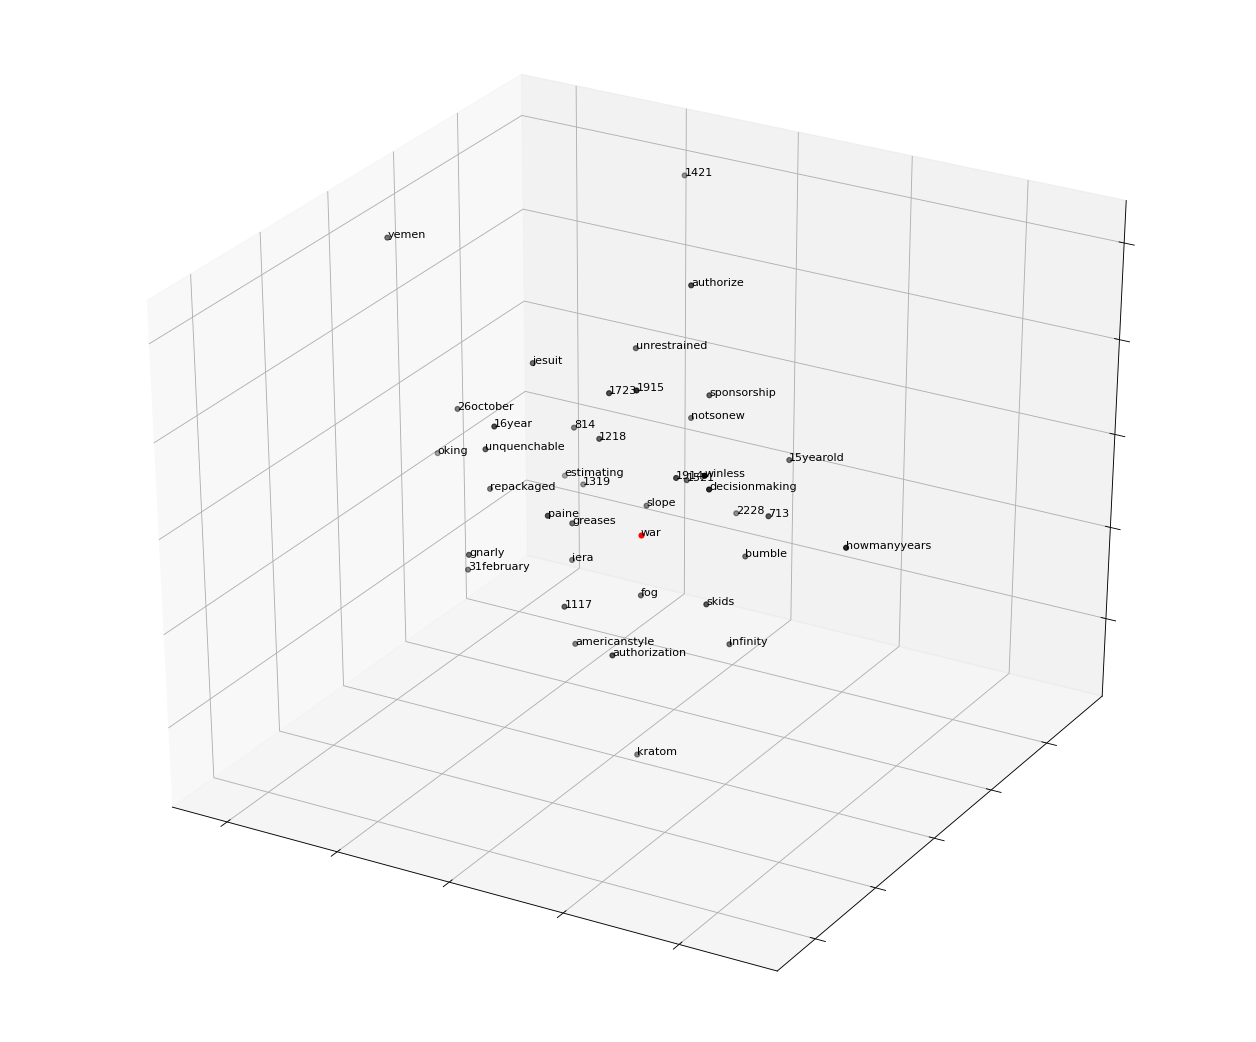

In [125]:
embedding_space_visualization("war", embedding_model)

 # **Feature Engineering**

In [126]:
tokenizer = Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  # tokenize text
tokenizer.fit_on_texts(lst_corpus)
index_of_words = tokenizer.word_index
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)    ## create sequence
train_x = pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post") # pad sequences 

corpus = test_set["text_clean"]

lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

test_x = pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")

In [127]:
print(train_x)
print(len(train_x))
print(test_x)
print(len(test_x))

[[1403 1250  345 ...    0    0    0]
 [4587 9453 8123 ...    0    0    0]
 [2036  366  698 ...    0    0    0]
 ...
 [   5  562   77 ... 3089    0    0]
 [ 235   11    5 ...    0    0    0]
 [   2  445    4 ...    0    0    0]]
40703
[[1904 2461 1136 ...    0    0    0]
 [   1 1745   48 ...    0    0    0]
 [4792    1 2318 ...    0    0    0]
 ...
 [   1  649   58 ...    0    0    0]
 [ 494    1    2 ...    0    0    0]
 [2560   25  867 ...    0    0    0]]
10176


# **Embeddings Matrix Building**

In [128]:
embeddings_matrix = np.zeros((len(index_of_words)+1, 300))
for word, idx in index_of_words.items():
    try:
        embeddings_matrix[idx] =  embedding_model[word]
    except:
        pass
print(embeddings_matrix.shape)

(27072, 300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


# **Labels Encoding**

In [129]:
print("Original Labels: ")
print(train_y)
print(test_y)
lb_train = LabelEncoder()
lb_train.fit(train_y)
train_y = lb_train.transform(train_y)

lb_test = LabelEncoder()
lb_test.fit(test_y)
test_y = lb_test.transform(test_y)

# save label file so we can use in another script
np.save('./train_labels.npy', lb_train.classes_)
np.save('./test_labels.npy', lb_test.classes_)
print("Encoded Labels: ")
print(train_y)
print(test_y)
n_classes = len(np.unique(train_y))

Original Labels: 
['POLITICS' 'POLITICS' 'POLITICS' ... 'POLITICS' 'POLITICS' 'POLITICS']
['POLITICS' 'ENTERTAINMENT' 'POLITICS' ... 'POLITICS' 'ENTERTAINMENT'
 'ENTERTAINMENT']
Encoded Labels: 
[1 1 1 ... 1 1 1]
[1 0 1 ... 1 0 0]


# **One-Hot Encoding of Outputs**

In [130]:
n_classes

3

In [131]:
print("Original Labels: ")
print(train_y)
print(test_y)
train_y = to_categorical(train_y, num_classes = n_classes)
test_y = to_categorical(test_y, num_classes = n_classes)
print("One-Hot Encoded Labels: ")
print(train_y)
print(test_y)
print(len(train_y))
print(len(test_y))


Original Labels: 
[1 1 1 ... 1 1 1]
[1 0 1 ... 1 0 0]
One-Hot Encoded Labels: 
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
40703
10176


# **Deep Learning Model Definition**

In [132]:
input = Input(shape=(15,))
x = Embedding(input_dim=embeddings_matrix.shape[0], output_dim=embeddings_matrix.shape[1], weights=[embeddings_matrix], input_length=15, trainable=False)(input)
x = Bidirectional(LSTM(units=15, dropout=0.2, return_sequences=True))(x)
x = Bidirectional(LSTM(units=15, dropout=0.2))(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(input, predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 15, 300)           8121600   
                                                                 
 bidirectional_6 (Bidirectio  (None, 15, 30)           37920     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 30)               5520      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                1984      
                                                                 
 dense_7 (Dense)             (None, 3)                 195 

In [133]:
if save_best_model is True:
  if benchmark is True: 
    checkPoint=ModelCheckpoint(model_path+"best_bilstm_news_classifier.h5", save_weights_only=True, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  else: 
    checkPoint=ModelCheckpoint(model_path+"best_bilstm_hashtags_classifier.h5", save_weights_only=True, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  default_callbacks = default_callbacks+[checkPoint]

if early_stopping is True: 
  earlyStopping=EarlyStopping(monitor='val_loss', min_delta = 0.001, patience=7, verbose=0, mode='min') 
  default_callbacks = default_callbacks+[earlyStopping]

# **Deep Learning Model Training**

In [134]:
history = training = model.fit(train_x, train_y, batch_size=64, epochs=100, shuffle=True, verbose=1, callbacks = default_callbacks, validation_split=0.2)

Epoch 1/100
505/509 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8903
Epoch 1: val_accuracy improved from -inf to 0.92937, saving model to /content/drive/MyDrive/DL_Models/best_bilstm_news_classifier.h5
509/509 [==============================] - 13s 14ms/step - loss: 0.3095 - accuracy: 0.8905 - val_loss: 0.2052 - val_accuracy: 0.9294
Epoch 2/100
506/509 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9273
Epoch 2: val_accuracy improved from 0.92937 to 0.93404, saving model to /content/drive/MyDrive/DL_Models/best_bilstm_news_classifier.h5
509/509 [==============================] - 6s 12ms/step - loss: 0.2089 - accuracy: 0.9272 - val_loss: 0.1915 - val_accuracy: 0.9340
Epoch 3/100
505/509 [============================>.] - ETA: 0s - loss: 0.1901 - accuracy: 0.9327
Epoch 3: val_accuracy improved from 0.93404 to 0.93834, saving model to /content/drive/MyDrive/DL_Models/best_bilstm_news_classifier.h5
509/509 [==============================

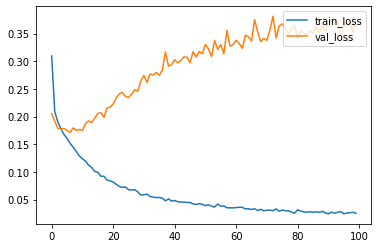

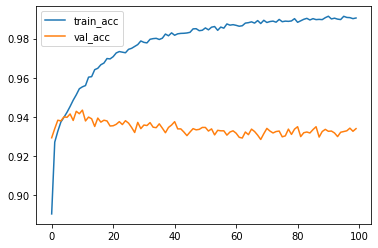

In [135]:
plot_loss(history)
plot_acc(history)

In [136]:
score = model.evaluate(test_x, test_y, batch_size=500)
print(score)

21/21 [==============================] - 0s 5ms/step - loss: 0.7177 - accuracy: 0.8600
[0.7176964282989502, 0.8599646091461182]
